In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

In [2]:
torch.__version__

'1.9.0'

# 数据准备

In [3]:
# 对数据做归一化 （-1， 1）
transform = transforms.Compose([
    transforms.ToTensor(),         # 0-1; channel, high, witch,
    transforms.Normalize(0.5, 0.5)
])

In [4]:
train_ds = torchvision.datasets.MNIST('data',
                                      train=True,
                                      transform=transform,
                                      download=True)

In [5]:
dataloader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)

In [6]:
imgs, _ = next(iter(dataloader))

In [7]:
imgs.shape

torch.Size([64, 1, 28, 28])

# 定义生成器

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
                                  nn.Linear(100, 256),
                                  nn.ReLU(),
                                  nn.Linear(256, 512),
                                  nn.ReLU(),
                                  nn.Linear(512, 28*28),
                                  nn.Tanh()                     # -1, 1之间
        )
    def forward(self, x):              # x 表示长度为100 的noise输入
        img = self.main(x)
        img = img.view(-1, 28, 28)
        return img

# 定义判别器

In [9]:
## 输入为（1， 28， 28）的图片  输出为二分类的概率值，输出使用sigmoid激活 0-1
# BCEloss计算交叉熵损失

# nn.LeakyReLU   f(x) : x>0 输出 0， 如果x<0 ,输出 a*x  a表示一个很小的斜率，比如0.1
# 判别器中一般推荐使用 LeakyReLU

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
                                  nn.Linear(28*28, 512),
                                  nn.LeakyReLU(),
                                  nn.Linear(512, 256),
                                  nn.LeakyReLU(),
                                  nn.Linear(256, 1),
                                  nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.main(x)
        return x

# 初始化模型、优化器及损失计算函数

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
gen = Generator().to(device)
dis = Discriminator().to(device)

In [13]:
d_optim = torch.optim.Adam(dis.parameters(), lr=0.0001)
g_optim = torch.optim.Adam(gen.parameters(), lr=0.0001)

In [14]:
loss_fn = torch.nn.BCELoss()

# 绘图函数

In [15]:
def gen_img_plot(model, test_input):
    prediction = np.squeeze(model(test_input).detach().cpu().numpy())
    fig = plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow((prediction[i] + 1)/2)
        plt.axis('off')
    plt.show()

In [16]:
test_input = torch.randn(16, 100, device=device)

# GAN的训练

In [17]:
D_loss = []
G_loss = []

Epoch: 0


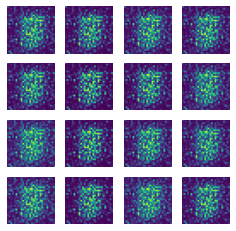

Epoch: 1


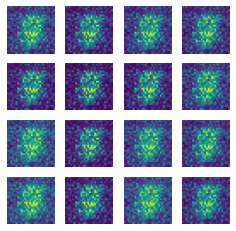

Epoch: 2


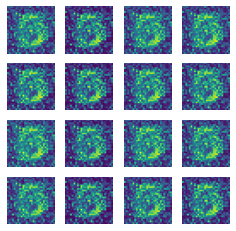

Epoch: 3


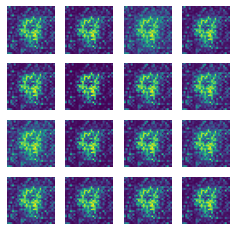

Epoch: 4


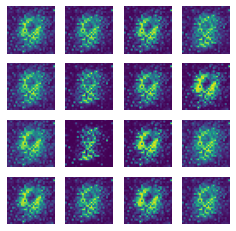

Epoch: 5


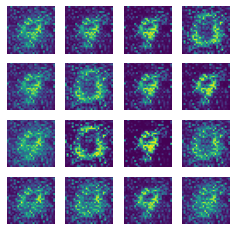

Epoch: 6


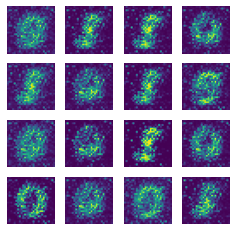

Epoch: 7


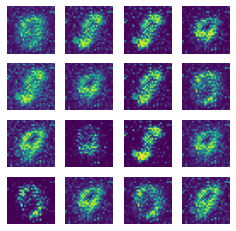

Epoch: 8


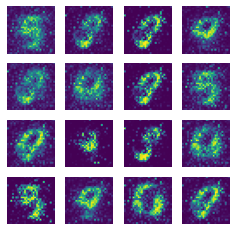

Epoch: 9


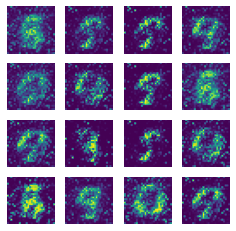

Epoch: 10


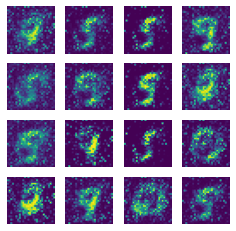

Epoch: 11


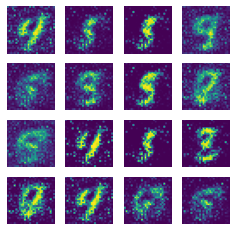

Epoch: 12


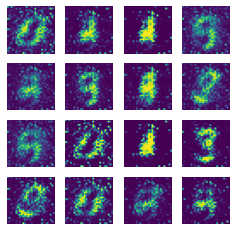

Epoch: 13


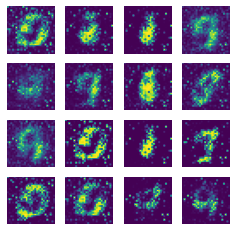

Epoch: 14


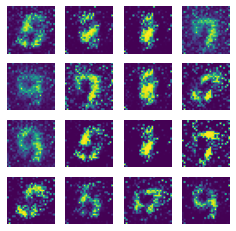

Epoch: 15


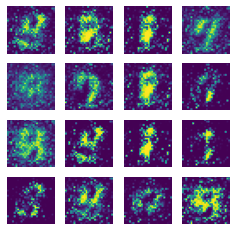

Epoch: 16


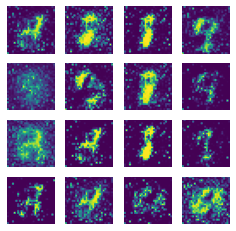

Epoch: 17


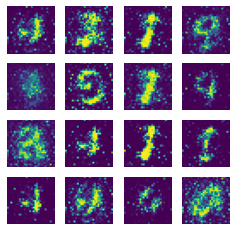

Epoch: 18


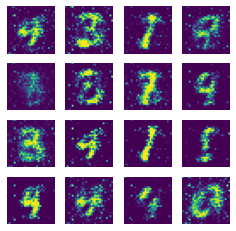

Epoch: 19


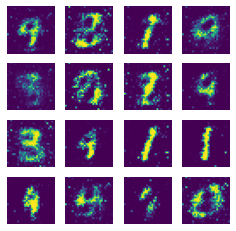

In [18]:
# 训练循环
for epoch in range(20):
    d_epoch_loss = 0
    g_epoch_loss = 0
    count = len(dataloader)
    for step, (img, _) in enumerate(dataloader):
        img = img.to(device)
        size = img.size(0)
        random_noise = torch.randn(size, 100, device=device)
        
        d_optim.zero_grad()
        
        real_output = dis(img)      # 判别器输入真实的图片，real_output对真实图片的预测结果 
        d_real_loss = loss_fn(real_output, 
                              torch.ones_like(real_output))      # 得到判别器在真实图像上的损失
        d_real_loss.backward()
        
        gen_img = gen(random_noise)
        # 判别器输入生成的图片，fake_output对生成图片的预测
        fake_output = dis(gen_img.detach()) 
        d_fake_loss = loss_fn(fake_output, 
                              torch.zeros_like(fake_output))      # 得到判别器在生成图像上的损失
        d_fake_loss.backward()
        
        d_loss = d_real_loss + d_fake_loss
        d_optim.step()
        
        g_optim.zero_grad()
        fake_output = dis(gen_img)
        g_loss = loss_fn(fake_output, 
                         torch.ones_like(fake_output))      # 生成器的损失
        g_loss.backward()
        g_optim.step()
        
        with torch.no_grad():
            d_epoch_loss += d_loss
            g_epoch_loss += g_loss
            
    with torch.no_grad():
        d_epoch_loss /= count
        g_epoch_loss /= count
        D_loss.append(d_epoch_loss.item())
        G_loss.append(g_epoch_loss.item())
        print('Epoch:', epoch)
        gen_img_plot(gen, test_input)